버스 정류장 도착 시간 예측

## 프로젝트 목적 



증가하는 제주도 상주인구로 인한 교통난을 해결하고 효율적인 버스 운행을 위해 운행 시간을 예측하는 모델 개발
예측성능을 높이기 위해 xgboost 사용하고 
K-fold를 이용하여 K-validation을 수행합니다.


## 미니 프로젝트 목적
해당 날짜 별, 노선 및 버스 ID가 주어진 상황에서 현재 정류소의 이름과 현재 정류장 도착 시간을 이용하여,

다음 정류장에 도착할 때까지 걸리는 시간을 예측하기 위한 데이터를 제공해 드립니다

In [ ]:
import numpy as np # 행렬 연산 / 데이터 핸들링
import pandas as pd # 데이터 분석
import matplotlib.pyplot as plt # 그래프 시각화
import seaborn as sns # 그래프 시각화
from xgboost import XGBRegressor # XGBoost Regressor 모델
from sklearn.model_selection import KFold # K-validation
from sklearn.metrics import accuracy_score # 정확도 측정 함수
from sklearn.preprocessing import LabelEncoder # 라벨 인코더

## 데이터 설명 

In [ ]:
# 해당 날짜 별, 노선과 버스 ID가 주어지고 
# 현재 정류장의 이름과 도착시간을 이용하여 다음 정류장에 도착할 때까지 걸리는 시간을 예측

### 학습 / 테스트 데이터 

In [ ]:
bus_te = pd.read_csv('test.csv', sep=',')
bus_tr = pd.read_csv('train.csv', sep=',')

In [ ]:
bus_tr

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210452,210452,2019-10-28,405328102,7983486,281-2,33.255783,126.577450,비석거리,21시,528.0,삼아아파트,33.251896,126.574417,96
210453,210453,2019-10-28,405328102,7983486,281-2,33.248595,126.568527,동문로터리,21시,280.0,매일올레시장 7번입구,33.249753,126.565959,50
210454,210454,2019-10-28,405328102,7983486,281-2,33.251891,126.560303,서귀포시 구 버스터미널,21시,114.0,아랑조을거리 입구,33.251084,126.559551,16
210455,210455,2019-10-28,405328102,7983486,281-2,33.251084,126.559551,아랑조을거리 입구,21시,223.0,평생학습관,33.249504,126.558068,38


In [ ]:
bus_te

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude
0,210457,2019-10-29,405136001,7997025,360-1,33.457724,126.554014,제대마을,07시,333.0,제대아파트,33.458783,126.557353
1,210458,2019-10-29,405136001,7997025,360-1,33.458783,126.557353,제대아파트,07시,415.0,제주대학교,33.459893,126.561624
2,210459,2019-10-29,405136001,7997025,360-1,33.478867,126.483833,한라중학교/부영아파트,08시,417.0,대림2차아파트,33.478850,126.488350
3,210460,2019-10-29,405136001,7997025,360-1,33.478850,126.488350,대림2차아파트,08시,334.0,연동대림1차아파트,33.480700,126.489933
4,210461,2019-10-29,405136001,7997025,360-1,33.480700,126.489933,연동대림1차아파트,08시,550.0,케이티앤지,33.482077,126.485355
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91769,302350,2019-11-05,405328102,7983486,281-2,33.493625,126.534764,제주지방법원(광양방면),20시,272.0,고산동산(광양방면),33.495540,126.532907
91770,302351,2019-11-05,405328102,7983486,281-2,33.495540,126.532907,고산동산(광양방면),20시,447.0,제주시청(광양방면),33.498925,126.530351
91771,302352,2019-11-05,405328102,7983486,281-2,33.498925,126.530351,제주시청(광양방면),20시,418.0,광양사거리,33.500473,126.527103
91772,302353,2019-11-05,405328102,7983486,281-2,33.500473,126.527103,광양사거리,20시,140.0,탐라장애인 종합복지관,33.500228,126.525625


In [ ]:
bus_tr.shape, bus_te.shape

((210457, 14), (91774, 13))

In [ ]:
bus_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210457 entries, 0 to 210456
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                210457 non-null  int64  
 1   date              210457 non-null  object 
 2   route_id          210457 non-null  int64  
 3   vh_id             210457 non-null  int64  
 4   route_nm          210457 non-null  object 
 5   now_latitude      210457 non-null  float64
 6   now_longitude     210457 non-null  float64
 7   now_station       210457 non-null  object 
 8   now_arrive_time   210457 non-null  object 
 9   distance          210457 non-null  float64
 10  next_station      210457 non-null  object 
 11  next_latitude     210457 non-null  float64
 12  next_longitude    210457 non-null  float64
 13  next_arrive_time  210457 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 22.5+ MB


In [8]:
bus_tr.isna().sum()

id                  0
date                0
route_id            0
vh_id               0
route_nm            0
now_latitude        0
now_longitude       0
now_station         0
now_arrive_time     0
distance            0
next_station        0
next_latitude       0
next_longitude      0
next_arrive_time    0
dtype: int64

In [9]:
bus_te.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91774 entries, 0 to 91773
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               91774 non-null  int64  
 1   date             91774 non-null  object 
 2   route_id         91774 non-null  int64  
 3   vh_id            91774 non-null  int64  
 4   route_nm         91774 non-null  object 
 5   now_latitude     91774 non-null  float64
 6   now_longitude    91774 non-null  float64
 7   now_station      91774 non-null  object 
 8   now_arrive_time  91774 non-null  object 
 9   distance         91774 non-null  float64
 10  next_station     91774 non-null  object 
 11  next_latitude    91774 non-null  float64
 12  next_longitude   91774 non-null  float64
dtypes: float64(5), int64(3), object(5)
memory usage: 9.1+ MB


In [10]:
bus_te.isna().sum()

id                 0
date               0
route_id           0
vh_id              0
route_nm           0
now_latitude       0
now_longitude      0
now_station        0
now_arrive_time    0
distance           0
next_station       0
next_latitude      0
next_longitude     0
dtype: int64

## 데이터 전처리 

#### 정류장 이름 인코딩

In [11]:
station = list(bus_tr['now_station'].values) + list(bus_tr['next_station'].values) # train 의 모든 정류장 이름
station_set = set(station)
print(len(station_set))

351


In [12]:
station_encoder = LabelEncoder()        # 인코더 생성
station_encoder.fit(list(station_set))  # 인코딩 

# train 정류장 치환
bus_tr['now_station'] = station_encoder.transform(bus_tr['now_station'])
bus_tr['next_station'] = station_encoder.transform(bus_tr['next_station'])

# test 정류장 치환 
bus_te['now_station'] = station_encoder.transform(bus_te['now_station'])
bus_te['next_station'] = station_encoder.transform(bus_te['next_station'])
bus_tr.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,239,06시,266.0,227,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,227,06시,333.0,228,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,228,06시,415.0,235,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,41,06시,578.0,249,33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,63,07시,374.0,221,33.485822,126.490897,64


#### 필요없는 featuere 제거

In [13]:
# train

bus_tr = bus_tr.drop(['id', 'route_nm', 'next_latitude', 'next_longitude', 
                              'now_latitude', 'now_longitude'], axis=1)
bus_tr.head()

,date,route_id,vh_id,now_station,now_arrive_time,distance,next_station,next_arrive_time
0,2019-10-15,405136001,7997025,239,06시,266.0,227,24
1,2019-10-15,405136001,7997025,227,06시,333.0,228,36
2,2019-10-15,405136001,7997025,228,06시,415.0,235,40
3,2019-10-15,405136001,7997025,41,06시,578.0,249,42
4,2019-10-15,405136001,7997025,63,07시,374.0,221,64


In [14]:
# test
bus_te = bus_te.drop(['route_nm', 'next_latitude', 'next_longitude', 
                              'now_latitude', 'now_longitude'], axis=1)
bus_te.head()

,id,date,route_id,vh_id,now_station,now_arrive_time,distance,next_station
0,210457,2019-10-29,405136001,7997025,227,07시,333.0,228
1,210458,2019-10-29,405136001,7997025,228,07시,415.0,235
2,210459,2019-10-29,405136001,7997025,323,08시,417.0,59
3,210460,2019-10-29,405136001,7997025,59,08시,334.0,183
4,210461,2019-10-29,405136001,7997025,183,08시,550.0,285


#### 날짜 -> 요일

In [15]:
# train 

bus_tr['date'] = pd.to_datetime(bus_tr['date']) # date 값을 datetime으로
bus_tr['weekday'] = bus_tr['date'].dt.weekday  # Monday 0 ~ Sunday 6 
bus_tr = bus_tr.drop('date', axis=1) # 필요없는 date 칼럼을 drop
bus_tr.head()

,route_id,vh_id,now_station,now_arrive_time,distance,next_station,next_arrive_time,weekday
0,405136001,7997025,239,06시,266.0,227,24,1
1,405136001,7997025,227,06시,333.0,228,36,1
2,405136001,7997025,228,06시,415.0,235,40,1
3,405136001,7997025,41,06시,578.0,249,42,1
4,405136001,7997025,63,07시,374.0,221,64,1


In [16]:
bus_tr['weekday'].unique()

array([1, 2, 3, 4, 5, 6, 0], dtype=int64)

In [17]:
# test

bus_te['date'] = pd.to_datetime(bus_te['date'])
bus_te['weekday'] = bus_te['date'].dt.weekday 
bus_te = bus_te.drop('date', axis=1)
bus_te.head()

,id,route_id,vh_id,now_station,now_arrive_time,distance,next_station,weekday
0,210457,405136001,7997025,227,07시,333.0,228,1
1,210458,405136001,7997025,228,07시,415.0,235,1
2,210459,405136001,7997025,323,08시,417.0,59,1
3,210460,405136001,7997025,59,08시,334.0,183,1
4,210461,405136001,7997025,183,08시,550.0,285,1


#### now_arrive_time -> 정수형으로 "06시" -> "06"

In [18]:
np.sort(bus_tr['now_arrive_time'].unique())
# 01시 ~ 04시의 데이터가 존재하지 않는다

array(['00시', '05시', '06시', '07시', '08시', '09시', '10시', '11시', '12시',
       '13시', '14시', '15시', '16시', '17시', '18시', '19시', '20시', '21시',
       '22시', '23시'], dtype=object)

C:\Users\ICT01_11\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ICT01_11\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)


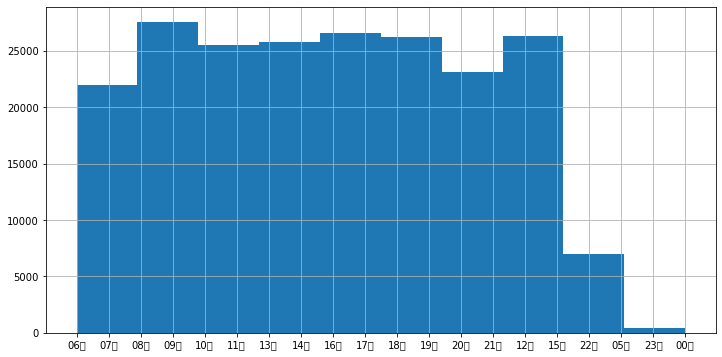

In [19]:
time = bus_tr['now_arrive_time']

plt.figure(figsize=(12,6))
plt.hist(time)
plt.grid(True)
plt.show()

시간대 구분
- 오전 = 1 : 05 ~ 11시
- 오후 = 2 : 12 ~ 17시
- 저녁 = 3 : 18 ~ 00시 

In [20]:
# train

bus_tr['time_group']=0

bus_tr.loc[ (bus_tr['now_arrive_time']>='05시') & (bus_tr['now_arrive_time']<'12시') ,['time_group'] ]= 1   # 오전
bus_tr.loc[ (bus_tr['now_arrive_time']>='12시') & (bus_tr['now_arrive_time']<'18시') ,['time_group'] ]= 2   # 오후
bus_tr.loc[ (bus_tr['now_arrive_time']>='18시') | (bus_tr['now_arrive_time']=='00시'),['time_group'] ]= 3   # 저녁

bus_tr = bus_tr.drop('now_arrive_time', axis=1) 
bus_tr.head()

,route_id,vh_id,now_station,distance,next_station,next_arrive_time,weekday,time_group
0,405136001,7997025,239,266.0,227,24,1,1
1,405136001,7997025,227,333.0,228,36,1,1
2,405136001,7997025,228,415.0,235,40,1,1
3,405136001,7997025,41,578.0,249,42,1,1
4,405136001,7997025,63,374.0,221,64,1,1


In [21]:
bus_tr['time_group'].value_counts()

2    78634
1    75550
3    56273
Name: time_group, dtype: int64

In [22]:
# test data

bus_te['time_group']= 0 

bus_te.loc[ (bus_te['now_arrive_time']>='05시') & (bus_te['now_arrive_time']<'12시') ,['time_group'] ]= 1   # 오전
bus_te.loc[ (bus_te['now_arrive_time']>='12시') & (bus_te['now_arrive_time']<'18시') ,['time_group'] ]= 2   # 오후
bus_te.loc[ (bus_te['now_arrive_time']>='18시') | (bus_te['now_arrive_time']=='00시'),['time_group'] ]= 3   # 저녁

bus_te = bus_te.drop('now_arrive_time', axis=1)
bus_te.head()

,id,route_id,vh_id,now_station,distance,next_station,weekday,time_group
0,210457,405136001,7997025,227,333.0,228,1,1
1,210458,405136001,7997025,228,415.0,235,1,1
2,210459,405136001,7997025,323,417.0,59,1,1
3,210460,405136001,7997025,59,334.0,183,1,1
4,210461,405136001,7997025,183,550.0,285,1,1


In [23]:
bus_te['time_group'].value_counts()

2    34384
1    32006
3    25384
Name: time_group, dtype: int64

## 시각화

In [24]:
# plt.figure(figsize=(10,15))
# bus_tr.plot(kind='bar', rot=0)
# plt.title('Next arrive time by weekday', fontsize=20)
# plt.xlabel('weekday', fontsize=14)
# plt.ylabel('next_arrive_time', fontsize=14)
# plt.ylim(200000, 480000)
# plt.show()


In [25]:
# 상관관계 
corr_df = bus_tr.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
corr_df

,route_id,vh_id,now_station,distance,next_station,next_arrive_time,weekday,time_group
route_id,1.00,-1.00,-0.04,0.10,-0.05,-0.16,0.02,0.00
vh_id,-1.00,1.00,0.04,-0.10,0.05,0.16,-0.02,-0.00
now_station,-0.04,0.04,1.00,-0.01,0.11,0.01,0.00,-0.00
distance,0.10,-0.10,-0.01,1.00,-0.02,0.44,0.00,-0.01
next_station,-0.05,0.05,0.11,-0.02,1.00,0.01,-0.00,0.00
next_arrive_time,-0.16,0.16,0.01,0.44,0.01,1.00,-0.01,0.00
weekday,0.02,-0.02,0.00,0.00,-0.00,-0.01,1.00,0.01
time_group,0.00,-0.00,-0.00,-0.01,0.00,0.00,0.01,1.00


<AxesSubplot:>

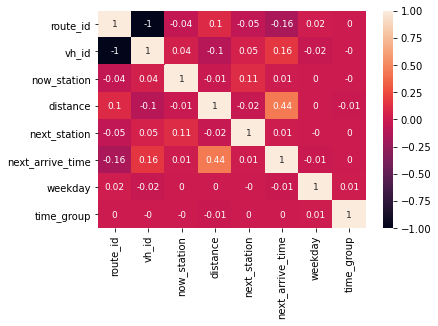

In [40]:
data = bus_tr.corr(method='pearson').round(2)
sns.heatmap(data=data, annot=True, annot_kws={"size":9}, )

In [33]:
weekday_g = bus_tr.groupby(bus_tr['weekday'])
weekday_g.mean()

,route_id,vh_id,now_station,distance,next_station,next_arrive_time,time_group
weekday,,,,,,,
0,4.052489e+08,7.988716e+06,175.030178,488.106975,177.685534,85.926136,1.909729
1,4.052472e+08,7.988832e+06,174.407684,487.031522,178.121874,85.476095,1.897831
2,4.052471e+08,7.988846e+06,174.823837,489.199267,177.583036,86.133721,1.900578
3,4.052475e+08,7.988814e+06,174.488924,490.255748,177.833699,86.487632,1.897184
4,4.052470e+08,7.988854e+06,174.406626,490.293404,177.472353,86.913709,1.925774
5,4.052536e+08,7.988353e+06,175.255329,492.335868,177.993682,83.720544,1.902520
6,4.052530e+08,7.988396e+06,175.250443,495.141145,177.254202,82.714732,1.927122


In [34]:
time_g = bus_tr.groupby(bus_tr['time_group'])
time_g.mean()

,route_id,vh_id,now_station,distance,next_station,next_arrive_time,weekday
time_group,,,,,,,
1,4.052472e+08,7.988833e+06,175.311198,489.450589,177.498729,84.876360,2.929557
2,4.052525e+08,7.988433e+06,174.521810,498.610665,177.752423,85.677722,2.932345
3,4.052469e+08,7.988872e+06,174.499209,479.663160,177.938994,85.643221,2.970714


In [35]:
bus_tr.groupby(bus_tr['distance'])['next_arrive_time'].plot


,route_id,vh_id,now_station,next_station,next_arrive_time,weekday,time_group
distance,,,,,,,
97.0,4.053201e+08,7.983091e+06,195.000000,4.000000,17.657143,2.996825,1.977778
110.0,4.053201e+08,7.983063e+06,348.000000,82.000000,39.000000,3.000000,1.833333
114.0,4.053243e+08,7.983269e+06,158.135402,141.864598,45.833568,2.919605,1.903385
120.0,4.053201e+08,7.983074e+06,79.521127,124.478873,38.295775,3.126761,1.929577
134.0,4.053201e+08,7.983090e+06,131.377224,131.622776,22.868327,3.028470,1.839858
...,...,...,...,...,...,...,...
3469.0,4.053281e+08,7.983444e+06,152.000000,224.000000,197.685393,2.876404,1.988764
4397.0,4.053281e+08,7.983434e+06,106.500000,59.500000,307.771552,3.161638,1.855603
4429.0,4.053281e+08,7.983447e+06,57.034884,108.965116,309.953488,2.947674,1.799419


In [29]:
n_arrive_time_by_wd = bus_tr[['weekday','next_arrive_time']].groupby('').sum()
n_arrive_time_by_wd

KeyError: ''

In [41]:
plt.figure(figsize=(10,15))
n_arrive_time_by_wd.plot(kind='bar', rot=0)
plt.title('Next arrive time by weekday', fontsize=20)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Sum of Passengers', fontsize=14)
plt.ylim(200000, 480000)
plt.show()

NameError: name 'n_arrive_time_by_wd' is not defined

<Figure size 720x1080 with 0 Axes>

In [ ]:
n_arrive_time_by_wd = n_arrive_time_by_wd.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
n_arrive_time_by_wd

In [39]:
bus_tr['route_id'].value_counts()

405136522    31941
405328102    25884
405136001    21668
405328101    19150
405320116    15451
405320114    12999
405320112    11871
405136521    11826
405136012     8037
405320111     7895
405320122     7723
405136002     7709
405320127     5950
405320117     5102
405320121     2670
405320126     2665
405320113     2631
405320118     2558
405320124     2368
405320115     2289
405136007     2070
Name: route_id, dtype: int64

In [37]:
bus_tr[bus_tr['route_id']==405136001]

,route_id,vh_id,now_station,distance,next_station,next_arrive_time,weekday,time_group
0,405136001,7997025,239,266.0,227,24,1,1
1,405136001,7997025,227,333.0,228,36,1,1
2,405136001,7997025,228,415.0,235,40,1,1
3,405136001,7997025,41,578.0,249,42,1,1
4,405136001,7997025,63,374.0,221,64,1,1
...,...,...,...,...,...,...,...,...
197668,405136001,7997124,221,267.0,229,44,0,3
197669,405136001,7997124,231,244.0,91,86,0,3
197670,405136001,7997124,59,334.0,183,50,0,3
197671,405136001,7997124,185,455.0,240,58,0,3


In [ ]:
bus_tr[bus_tr['route_id']==405136001]

In [38]:
bus_tr.shape

(210457, 8)